# 1. Import

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms import ToPILImage
from IPython.display import display
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import os
import matplotlib.pyplot as plt

# 2. 데이터셋 Class정의

In [5]:
class CustomDataset(Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        self.fire_images = []
        self.non_fire_images = []

        # 화재 이미지 경로 설정
        fire_path = './fire_dataset/fire_images'
        fire_files = os.listdir(fire_path)
        for f in fire_files:
            img = Image.open(os.path.join(fire_path, f)).convert('RGB')
            self.fire_images.append(img)

        # 비화재 이미지 경로 설정
        non_fire_path = './fire_dataset/non_fire_images'
        non_fire_files = os.listdir(non_fire_path)
        for f in non_fire_files:
            img = Image.open(os.path.join(non_fire_path, f)).convert('RGB')
            self.non_fire_images.append(img)

    def __len__(self):
        # 데이터셋 전체 크기 반환
        return len(self.fire_images) + len(self.non_fire_images)

    def __getitem__(self, idx):
        if idx < len(self.fire_images):
            # idx가 화재 이미지의 개수보다 작으면 화재 이미지를 반환
            img = self.fire_images[idx]
            label = torch.tensor(1)  # 1: fire_images
        else:
            # idx가 화재 이미지의 개수 이상이면 비화재 이미지를 반환
            img = self.non_fire_images[idx - len(self.fire_images)]
            label = torch.tensor(0)  # 0: non_fire_images

        if self.transform:
            # 데이터셋 변환을 위한 transform이 설정되어 있으면 반환
            img = self.transform(img)

        return img, label

# 3. 데이터셋 생성 및 데이터전처리

In [6]:
#####################################################################################################################################
### Crop / flip / rotation을 사용하여 데이터 전처리 추가
transform = transforms.Compose([
    transforms.RandomResizedCrop(64),       ### 무작위로 이미지 일부를 잘라내어 (64, 64) 크기로 만듭니다.
    transforms.RandomHorizontalFlip(p=0.5),      ### 이미지를 무작위로 수평으로 뒤집습니다.
    transforms.RandomRotation(10),          ### 이미지를 최대 10도 무작위로 회전시킵니다.
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),                  ### 이미지를 Tensor로 변환합니다.
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # 이미지를 정규화합니다.
])
#####################################################################################################################################
# Custom 데이터셋 생성
dataset = CustomDataset(transform=transform)

# 4. 샘플이미지 확인

Fire Image 1


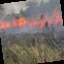

Fire Image 2


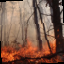

Fire Image 3


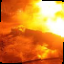

Fire Image 4


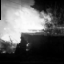

Non-Fire Image 1


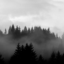

Non-Fire Image 2


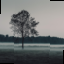

Non-Fire Image 3


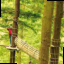

Non-Fire Image 4


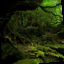

In [7]:
# 샘플 이미지 가져오기
fire_count = 0
non_fire_count = 0

# 샘플 이미지 출력 개수 정의
PRINT_NUM = 4

# 샘플 이미지 출력
for i in range(len(dataset)):
    sample_image, sample_label = dataset[i]
    
    if sample_label == 1 and fire_count < PRINT_NUM:
        # 화재 이미지 출력
        to_pil = ToPILImage()
        sample_image = to_pil(sample_image * 0.5 + 0.5)
        print(f"Fire Image {fire_count + 1}")
        display(sample_image)
        fire_count += 1
        
    elif sample_label == 0 and non_fire_count < PRINT_NUM:
        # 비화재 이미지 출력
        to_pil = ToPILImage()
        sample_image = to_pil(sample_image * 0.5 + 0.5)
        print(f"Non-Fire Image {non_fire_count + 1}")
        display(sample_image)
        non_fire_count += 1
        
    if fire_count >= PRINT_NUM and non_fire_count >= PRINT_NUM:
        # 화재와 비화재 이미지가 모두 4장씩 출력되면 종료
        break

## 5. 
## - 학습, 검증, 테스트 데이터 정의 
## - 데이터로더 정의
## - 설정 값 정의

In [8]:
# CUDA 사용 가능 여부 확인
USE_CUDA = torch.cuda.is_available()
# DEVICE 설정 (GPU 사용 가능 시 GPU 사용, 불가능 시 CPU 사용)
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
# 학습 설정 값
BATCH_SIZE = 128

train_size = int(0.6 * len(dataset))
val_size = test_size = int(0.2 * len(dataset))
if train_size + val_size + test_size != len(dataset):
    test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)
val_loader = DataLoader(val_dataset, 
                        batch_size=BATCH_SIZE, 
                        shuffle=False)
test_loader = DataLoader(test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False)

# 6. CNN모델 구축

In [9]:
#####################################################################################################################################
### Batch Normalization 을 사용하여 각 layer가 이전 layer출력에 덜 의존적이도록 변형하여 robust한 모델 구현
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  ### Batch Normalization 추가
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  ### Batch Normalization 추가
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)  ### Batch Normalization 추가
        
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 1)
#####################################################################################################################################
    def forward(self, x):
        ### Convolutional -> Batch Norm -> ReLU -> Pooling
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = torch.sigmoid(self.fc2(x))
        return x

In [18]:
# 모델 생성 및 모델을 CUDA 디바이스로 전송
model = CNN().to(DEVICE)

# 손실함수 정의
criterion = nn.BCELoss()

### Optimizer 정의 및 모델의 파라미터를 인자로 전달
optimizer = optim.Adam(model.parameters(), lr=0.0001)#lr=0.0001 ### learning rate를 기본(0.001)에서 0.0001로 낮춰줌
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#####################################################################################################################################
### scheduler를 사용하여 학습률 조정
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) ### 10 epoch마다 학습률을 0.1배로 줄입니다.
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min') # 검증 손실이 개선되지 않을 때 학습률을 줄입니다.

### early stopping을 위한 변수 선언 및 초기화
### early stopping: 학습 중 어느 시점부터 validation accuracy가 증가하지 않으면, 과적합 가능성이 있으므로 이를방지
### ▶ val loss가 감소하지 않으면 학습 중단

#best_val_loss = float('inf')
#patience = 0

#####################################################################################################################################


# 7. 평가 함수 정의

In [19]:
def eval_CNN(loader, model, criterion, device):
    # 모델을 평가 모드로 설정
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0

    with torch.no_grad():
        # DataLoader를 이용해 배치 단위로 데이터를 가져와 평가 진행
        for data in loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.float().unsqueeze(1))
            total_loss += loss.item()
            # 모델의 출력값을 반올림하여 예측값 계산
            predicted = torch.round(outputs.data)
            total += labels.size(0)
            # 예측값과 실제값이 일치하는 경우 정확도 증가
            correct += (predicted == labels.unsqueeze(1)).sum().item()

    # 정확도와 평균 손실 반환
    accuracy = 100 * correct / total
    return accuracy, total_loss / len(loader)

# 8. 학습 및 검증

In [20]:
EPOCHS = 30

In [21]:
for epoch in range(EPOCHS):
    # 모델을 학습 모드로 설정
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float().unsqueeze(1)) # 오차 계산
        loss.backward()
        optimizer.step() # 매개변수 업데이트
        running_loss += loss.item()

#####################################################################################################################################
### 위에 선언한 scheduler를 사용
    scheduler.step()  ### epoch마다 학습률을 갱신(adam용 scheduler)
    #scheduler.step(val_loss)  # 검증 손실을 기반으로 학습률을 갱신합니다.(sgd용 scheduler)
#####################################################################################################################################

    # 훈련 데이터와 검증 데이터의 정확도와 손실을 계산
    train_accuracy, train_loss = eval_CNN(train_loader, model, criterion, DEVICE)
    val_accuracy, val_loss = eval_CNN(val_loader, model, criterion, DEVICE)
    
#####################################################################################################################################
    ### early stopping 체크
#    if val_loss < best_val_loss:
#        best_val_loss = val_loss
#        patience = 0
#    else:
#        patience += 1
#        if patience > 5:  # patience는 실험적으로 결정할 수 있습니다.
#            print("Early stopping")
#            break
#####################################################################################################################################
    
    # 현재 epoch의 훈련과 검증 결과를 출력
    print('[Epoch %d] loss: %.3f, train_accuracy: %.2f%%, val_loss: %.3f, val_accuracy: %.2f%%'
          % (epoch + 1, running_loss / len(train_loader), train_accuracy, val_loss, val_accuracy))

print('Finished Training')

[Epoch 1] loss: 0.579, train_accuracy: 81.64%, val_loss: 0.668, val_accuracy: 83.92%
[Epoch 2] loss: 0.394, train_accuracy: 76.46%, val_loss: 0.572, val_accuracy: 72.86%
[Epoch 3] loss: 0.320, train_accuracy: 76.46%, val_loss: 0.492, val_accuracy: 72.86%
[Epoch 4] loss: 0.247, train_accuracy: 79.63%, val_loss: 0.412, val_accuracy: 74.37%
[Epoch 5] loss: 0.172, train_accuracy: 79.63%, val_loss: 0.459, val_accuracy: 76.88%
[Epoch 6] loss: 0.187, train_accuracy: 84.64%, val_loss: 0.438, val_accuracy: 79.90%
[Epoch 7] loss: 0.175, train_accuracy: 85.98%, val_loss: 0.432, val_accuracy: 81.91%
[Epoch 8] loss: 0.155, train_accuracy: 87.98%, val_loss: 0.287, val_accuracy: 87.94%
[Epoch 9] loss: 0.182, train_accuracy: 92.49%, val_loss: 0.180, val_accuracy: 91.46%
[Epoch 10] loss: 0.144, train_accuracy: 90.82%, val_loss: 0.256, val_accuracy: 87.94%
[Epoch 11] loss: 0.165, train_accuracy: 93.32%, val_loss: 0.210, val_accuracy: 89.45%
[Epoch 12] loss: 0.167, train_accuracy: 93.32%, val_loss: 0.226

# 9. TEST 성능 평가

In [22]:
test_accuracy, test_loss = eval_CNN(test_loader, model, criterion, DEVICE)
print('Test Loss: %.3f, Test Accuracy: %.2f%%' % (test_loss, test_accuracy))

Test Loss: 0.130, Test Accuracy: 94.53%
